# From Markdown to Meaning
**Turn Your Obsidian Notes into a Conversational Database Using LangChain, Python, and ChromaDB: A Practical Guide**

# Lost in Notes

If you're like me, your Obsidian vault has grown into a sprawling collection of hundreds of notes scattered across dozens of folders. I haven't fully utilised the tags function and haven't linked notes efficiently. So the majority of my notes are floating orphan nodes. What started as an organised knowledge management system has become an overwhelming maze where finding specific information feels like searching for a needle in a haystack.

Simple text searches return too many irrelevant results or miss contextually relevant notes that use different terminology. Even worse, I know that perfect piece of information exists somewhere in my vault, but I just can't remember which note contains it or what exact words I used.

I needed a smarter way to search through my notes—one that could understand context, find semantic relationships, and surface relevant information regardless of the specific words used.

# Surfacing What Matters

To solve this challenge, I built a system that processes all my Obsidian notes into a vector space, enabling intelligent querying through LangChain and Python. Here's what this solution accomplishes:

• **Semantic Search**: Transform notes into embeddings that capture meaning, not just keywords

• **OCR**: Extract text from linked screenshots and images and embed them into the notes 

• **Context Preservation**: Include original document headers and full path in every document chunk after splitting to maintain traceability

• **Cross-Note Connections**: Surface semantic relationships between notes that might otherwise remain hidden

• **Folder-Agnostic Retrieval**: Find relevant content regardless of how (or how poorly) your notes are organised

• **AI-Powered Synthesis**: Use ChatGPT or integrate with any AI-powered workflow to answer complex questions by combining information from multiple documents

# Document Retrieval Proof of Concept

For this proof of concept, I have vectorised a few documents related to Pentesting. Given the limited number of documents vectorised, the retrieved data from the Vector Space is impressive.

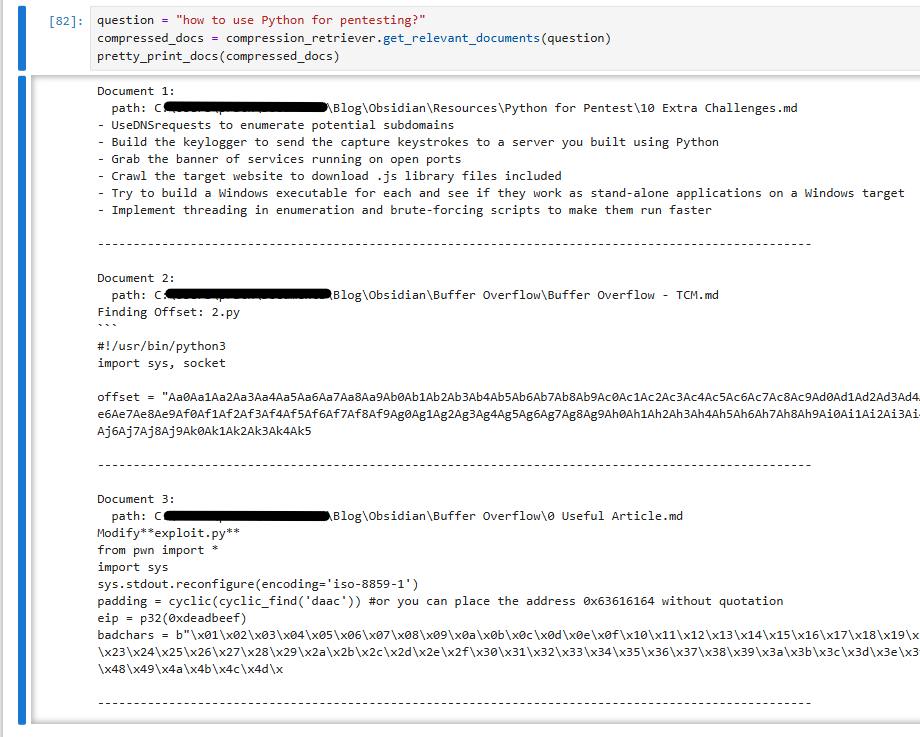

# Code Walkthrough: From Structure to Semantics

My goal is to recursively process every document in the Obsidian vault, extract text from embedded images (internal and external links, and seamlessly integrate that content back into the original document flow. After that, each document is stored in a ChromaDB vector store — with careful attention to preserving its context, structure, and metadata for meaningful retrieval.

For this demonstration, all code is executed within a Jupyter Notebook environment, which offers a highly interactive and modular workflow.

## Code Section 1: Setting Up the Required Packages and Environment

### Requirements

save the above as requirements.txt and then run the following command:

pip install -r requirements.txt

In [ ]:
!pip install langchain
!pip install langchain-chroma
!pip install langchain-community
!pip install langchain-openai
!pip install instructor
!pip install pytesseract Pillow
!pip install chromadb  

### Setting Up Your OpenAI API Key

To run the parts of this project that use OpenAI's models (for vector embedding, contextual retrieval, or generating answers), you'll need an OpenAI API key. his key authenticates your requests and links them to your OpenAI account. You can get your API key by:
- Signing in to your OpenAI account.
- Navigating to View API Keys in your account settings.
- Creating a new key and copying it somewhere safe.

    Option 1 — Store It as an Environment Variable (recommended)
This keeps your key out of your code and version control.
macOS / Linux (bash/zsh):
export OPENAI_API_KEY="your_api_key_here"


Windows (PowerShell):
setx OPENAI_API_KEY "your_api_key_here"


Then in Python:
import os
api_key = os.getenv("OPENAI_API_KEY")

Option 2 — Paste It Directly in Your Code (quick, but less secure)
If you’re just testing locally and want the fastest setup:
api_key = "your_api_key_here"


Warning: Avoid committing your API key to GitHub or sharing it publicly.


Tip: If you’re running this in a Jupyter Notebook, you can set the environment variable in a cell:
%env OPENAI_API_KEY=your_api_key_here


This will make it available to all subsequent cells in that notebook session.





### Loading the Obsidian Vault

In [ ]:
from langchain.document_loaders import ObsidianLoader
# Load Markdown files from Obsidian directory 
loader = ObsidianLoader(path="Path/To/Obsidian/Vault/", collect_metadata=True) 
documents = loader.load()
# Base directory for images 
image_base_path = "Path/To/Obsidian/Vault/Attachments/Folder"

## Code Section 2: Setting up Tesseract for OCR

I am using Tesseract OCR, as my use case involves converting screen-captured notes to text. Tesseract does not work well with handwritten notes. If you need OCR for handwritten notes, please follow the alternative solution I provided below for OCR.

To installTesseract on Windows:

Download and install the .exe file from GitHub - UB-Mannheim/tesseract: Tesseract Open Source OCR Engine (main repository)

Add Tesseract to your PATH

If you are using Jupyter Notebook, it is best to restart the Notebook.

In [ ]:
import pytesseract
from PIL import Image
import os

# Function to extract text from images 
def extract_text_from_image(image_path):
    try:
        img = Image.open(image_path)
        text = pytesseract.image_to_string(img)
        return text
    except UnidentifiedImageError:
        print(f"Cannot identify image file: {image_path}")
        return ""
        
# Function to extract text from image urls
def extract_text_from_image_url(image_url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
        'Referer': image_url,
        'Accept-Language': 'en-US,en;q=0.9'
    }

    attempts = 2  # Number of attempts
    session = requests.Session()  # Create a session object

    for attempt in range(attempts):
        try:
            response = session.get(image_url, headers=headers)
            response.raise_for_status()  # Check if the request was successful

            img = Image.open(BytesIO(response.content))
            text = pytesseract.image_to_string(img)
            return text
        except UnidentifiedImageError:
            print(f"Cannot identify image file from URL: {image_url}")
            return ""
        except requests.exceptions.RequestException as e:
            print(f"Error downloading image (attempt {attempt + 1}): {e}")
            if attempt < attempts - 1:
                print("Retrying...")
            else:
                return ""

### Alternative: Setting up EasyOCR for OCR

EasyOCR is suitable for extracting text from Handwritten notes. This is extremely sensitive as it will try to convert everything in the image into text. If you would like to use this OCR, you can follow this setup.

EasyOCR depends on PyTorch. Run this in your terminal:

In [ ]:
# For CPU only version:
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu

# For GPU version:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
!pip install easyocr

In [ ]:
import easyocr
import os
from PIL import Image, UnidentifiedImageError
import numpy as np
import cv2

def extract_text_from_image(image_path):
    reader = easyocr.Reader(['en'], gpu=True)  # You can add more languages like ['en', 'hi']
    results = reader.readtext(image_path, detail=0)  # detail=0 returns just the text
    return "\n".join(results)

def extract_text_from_image_url(image_url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
        'Referer': image_url,
        'Accept-Language': 'en-US,en;q=0.9'
    }

    attempts = 2
    session = requests.Session()
    reader = easyocr.Reader(['en'], gpu=True)

    for attempt in range(attempts):
        try:
            response = session.get(image_url, headers=headers)
            response.raise_for_status()

            # Convert image bytes to NumPy array for EasyOCR
            img_array = np.frombuffer(response.content, np.uint8)
            img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

            results = reader.readtext(img, detail=0)
            return "\n".join(results)

        except UnidentifiedImageError:
            print(f"Cannot identify image file from URL: {image_url}")
            return ""
        except requests.exceptions.RequestException as e:
            print(f"Error downloading image (attempt {attempt + 1}): {e}")
            if attempt < attempts - 1:
                print("Retrying...")
            else:
                return ""


## Code Section 3: Processing all the Obsidian notes to extract and embed text from the image links


In [ ]:
import requests
from io import BytesIO
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import urllib.parse

for doc in documents:
    content = doc.page_content  # Access the content attribute of the Document object
    doc_name = os.path.basename(doc.metadata['source'])  # Assuming the document metadata contains the source file path
    path = doc.metadata.get('path', 'Unknown path') # Extract the source from metadata
    lines = content.split('\n')
    for i, line in enumerate(lines):
        if line.startswith('![') and line.endswith(')'):
            # Handle image URL
            start_index = line.find('(') + 1
            end_index = line.find(')')
            image_url = line[start_index:end_index]
            extracted_text = extract_text_from_image_url(image_url)
            lines[i] += f"\nExtracted Text from {image_url}:\n{extracted_text}"
        elif line.startswith('![[') and line.endswith(']]'):
            # Handle local image path
            image_name = line[3:-2]  # Extract the image file name from the Markdown link
            image_path = os.path.join(image_base_path, image_name)
            if os.path.exists(image_path):
                # Extract text from the image using OCR
                extracted_text = extract_text_from_image(image_path)
                # Append the extracted text to the corresponding line in the document
                lines[i] += f"\nExtracted Text from {image_path}:\n{extracted_text}"
    # Update the document's content with the document name and modified lines
    doc.page_content = f"Document Name: {doc_name}\nPath: {path}\n\n" + '\n'.join(lines)

print(f"Total documents processed: {len(documents)}")

In [ ]:
print(documents[0].page_content)

An example of an image extraction and embedding. While it may not be the best, I am content considering my use case.

Sample:

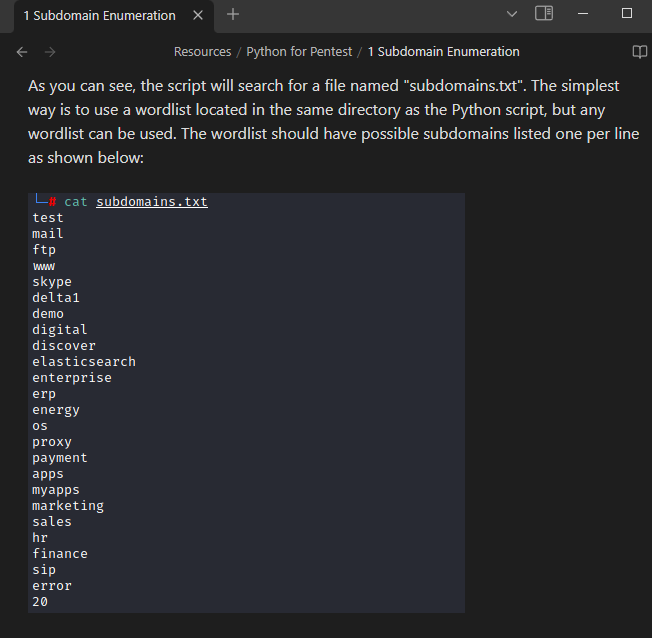
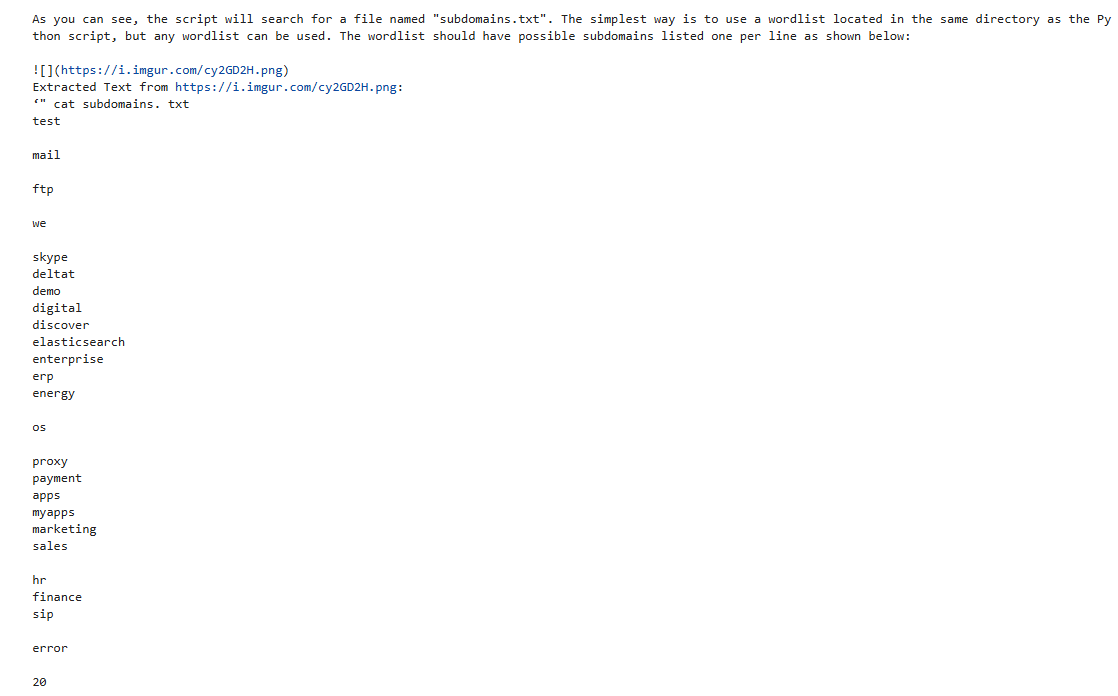

In [ ]:
print(documents[2].metadata)

## Code Section 4: Splitting by headings and chunks

When working with Markdown notes, headings (#, ##, ###) are boundaries that organise my content into meaningful sections. Splitting by headings first ensures that the context stays intact.

After splitting by headings, we still break longer sections into smaller overlapping chunks (e.g., 200–500 words) so they fit within embedding model limits and can be matched more precisely during search. This two‑step process — headings first, then chunking — gives the best balance between context preservation and retrieval accuracy.

In [ ]:
from langchain.text_splitter import MarkdownHeaderTextSplitter, RecursiveCharacterTextSplitter
from langchain.schema import Document  # Adjust the import based on your project structure

# Initialize the MarkdownHeaderTextSplitter to recognize headers from # to ####
header_splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=[("#", "Heading 1"), 
                         ("##", "Heading 2"), 
                         ("###", "Heading 3"), 
                         ("####", "Heading 4"), 
                         ("#####", "Heading 5"), 
                         ("######", "Heading 6")]
)

# Initialize a character-based splitter for chunking
chunk_size = 3500  # Set your desired chunk size
chunk_overlap = 300  # Set your desired chunk overlap
recursive_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)

all_chunks = []

for doc_index, doc in enumerate(documents):
    #print(f"Processing document {doc_index + 1}/{len(documents)}")

    if not isinstance(doc.page_content, str):
        print("Warning: Document page_content is not a string.")
        continue

    # Split document based on headers
    header_split_docs = header_splitter.split_text(doc.page_content)
    #print(f"Header split resulted in {len(header_split_docs)} parts for document {doc_index + 1}")

    # Convert split Documents into new Documents with consistent metadata
    for subdoc_index, subdoc in enumerate(header_split_docs):
        # Ensure subdoc is a Document object
        if isinstance(subdoc, Document):
            #print(f"Processing subdoc {subdoc_index + 1}/{len(header_split_docs)}")
            # Extract the content
            content = subdoc.page_content
            
            # Split the content into smaller chunks
            chunks = recursive_splitter.split_text(content)
            for chunk_index, chunk in enumerate(chunks):
                new_metadata = {
                    'path': doc.metadata.get('path', 'Unknown')
                }
                # Create a new Document for each chunk ensuring it retains metadata
                chunk_doc = Document(page_content=chunk, metadata=new_metadata)
                all_chunks.append(chunk_doc)
                #print(f"Created chunk {chunk_index + 1}/{len(chunks)} for subdoc {subdoc_index + 1}")
        else:
            print(f"Warning: Header split result {subdoc_index + 1} is not a Document.")

# Print the number of split documents created
print(f"Total number of chunks created: {len(all_chunks)}")

To confirm whether the metadata of the documents, such as document path, headings, etc., are preserved, you can use the following code.

In [ ]:
documents[0]

In [ ]:
all_chunks[3]

## Code Section 5: Building the Vector Store

A vector store is a database designed for storing and retrieving documents as embeddings — numerical representations that capture meaning rather than just keywords. Storing as embeddings allows the system to match concepts, not just exact words, powering more intelligent search and retrieval. ChromaDB stands out for being open‑source, easy to integrate with LangChain, and optimised for quick similarity searches. 

Using OpenAIEmbeddings, each chunk is converted into a high‑dimensional vector and saved in a persistent Chroma collection. The script then prints the total number of stored entries to confirm the database is ready.


In [ ]:
import langchain_openai
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
embedding = OpenAIEmbeddings()

In [ ]:
persist_directory = 'Add/the/Path/To/Create/Chroma'
collection_name = "Your_collection_name"

In [ ]:
embedding = OpenAIEmbeddings()
vectordb = Chroma(
    collection_name=collection_name,
    persist_directory=persist_directory,
    embedding_function=embedding
)

Once the documents are added to the vector store, the above code will print the list of the documents' UUID similar to the following:

In [ ]:
vectordb.add_documents(documents=all_chunks)

In [ ]:
print(vectordb._collection.count())

## Code Section 6: Implementing the Query System

There are several retriever tools to query the vector database. After several trials, I have found it best to take the following approach:

Initial Search
Start by fetching the top 20 documents most similar to the query using ChromaDB’s similarity scores (lower scores mean better matches).

Threshold Filtering
Only documents with a similarity score below 0.4 are kept — this filters out weak matches.

Embedding Preparation
The query and filtered documents are converted into embeddings (numerical vectors) for further comparison.

MMR Selection
Maximal Marginal Relevance (MMR) to re‑rank the results so they’re both highly relevant and diverse

Compression Layer
Finally, the selected documents are passed through a language model (GPT‑3.5) to compress and extract only the most useful context, making the output leaner and more focused.

This way, we retain only the most useful context, eliminating noise for accurate and focused document retrieval.

In [ ]:
import numpy as np
from typing import List
from langchain.schema import BaseRetriever, Document
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain.chains import RetrievalQA
from langchain_openai import OpenAI
from langchain.vectorstores.utils import maximal_marginal_relevance

score_threshold = 0.4  # lower = better in Chroma distances

class MMRThresholdRetriever(BaseRetriever):
    def _get_relevant_documents(self, query: str) -> List[Document]:
        # Step 1: fetch more docs with scores
        docs_and_scores = vectordb.similarity_search_with_score(query, k=20) # K here compared top 20 docs

        # Step 2: filter by threshold
        filtered = [(doc, score) for doc, score in docs_and_scores if score <= score_threshold]
        if not filtered:
            return []

        # Step 3: prepare embeddings as NumPy arrays
        query_emb = np.array(vectordb._embedding_function.embed_query(query))
        doc_embs = np.array([vectordb._embedding_function.embed_query(doc.page_content) for doc, _ in filtered])

        # Step 4: apply MMR
        selected_indices = maximal_marginal_relevance(query_emb, doc_embs, k=5, lambda_mult=0.7) # k here is to output max of 5 docs
        return [filtered[i][0] for i in selected_indices]

    async def _aget_relevant_documents(self, query: str) -> List[Document]:
        return self._get_relevant_documents(query)

# Instantiate retriever
mmr_retriever = MMRThresholdRetriever()

# Add compression
llm = OpenAI(model="gpt-3.5-turbo-instruct", temperature=0)
compressor = LLMChainExtractor.from_llm(llm)
compression_retriever = ContextualCompressionRetriever(
    base_retriever=mmr_retriever,
    base_compressor=compressor
)

def pretty_print_docs(docs):
    for i, d in enumerate(docs):
        # Print the document index, metadata, and content
        print(f"Document {i+1}:")
        #print("Metadata:")
        for key, value in d.metadata.items():
            print(f"  {key}: {value}")
        #print("\nContent:")
        print(d.page_content)
        print("\n" + "-" * 100 + "\n")

You can explore the diverse range of outputs by tweaking the values in the above code
Score_Threshold: Think of it as the “minimum pass mark” for results.
Higher → Only very strong matches make it through (more precise, but you might miss some useful ones).
Lower → Lets in weaker matches too (more coverage, but more noise).
K (Top‑K): How many top results do you look at before finetuning the list?
Higher → Casts a wider net (more variety, but slower and possibly less focused).
Lower → Narrower search (faster and more concentrated, but might miss some options).
Lambda_Mult: The balance between “most relevant” and “most different.”
Higher → Prioritises relevance over variety (results are closely related, but may be repetitive).
Lower → Prioritises variety over strict relevance (more diverse, but some results may be less on‑point).

In [ ]:
question = "Ask a question based on your notes"
print("\n=== Source Documents ===\n")
compressed_docs = compression_retriever.get_relevant_documents(question)
pretty_print_docs(compressed_docs)

Despite the maximum output value being set to 5 documents, the system retrieved only 1 document, as it identified that this was the most relevant one and filtered out the others because it was less relevant. Based on the small set of documents I vectorised, this is performing exceptionally well.

# Making Notes Conversational

Once the documents are transformed into vector embeddings and stored in the database, we've created a smart, queryable knowledge base that opens up powerful possibilities beyond simple search. The vectorised format allows us to seamlessly integrate with large language models (LLMs), enabling complex agentic workflows- automatically pulling relevant information from our knowledge base to inform decision-making, generate reports, or even trigger follow-up actions based on the content they discover. This is called Retrieval-Augmented Generation (RAG)

The beauty of this approach is that our documents become dynamic, accessible knowledge, turning our static note collection into an intelligent, responsive resource.

## A Simple RAG Demo

We'll use a simple code snippet to demonstrate RAG using RetrievalQA - a chain in LangChain, which enables LLMs to answer questions with context pulled from custom data sources. This results in answers that are more accurate, specific, and context-aware.

In [ ]:
from langchain.chains import RetrievalQA

# Create the RetrievalQA chain with the compression retriever
qa_llm = OpenAI(
    temperature=0,
    model="gpt-3.5-turbo-instruct"
)

qa_chain = RetrievalQA.from_chain_type(
    llm=qa_llm,
    retriever=compression_retriever,   # <-- our threshold-aware MMR + compression
    return_source_documents=True,
    chain_type="stuff"  # you can change to "map_reduce" or "refine" if needed
)


In [ ]:
question = "how to create key logger?"
result = qa_chain.invoke({"query": question})

print("\n=== Answer ===\n")
print(result["result"])

print("\n=== Source Documents ===\n")
pretty_print_docs(result["source_documents"])


If you found this approach helpful, I'd love to hear how you adapt it to your own workflow. Every note-taking setup is unique, and that's precisely what makes these kinds of experiments so rewarding.

Happy note-querying!